In [1]:
import numpy as np
from scipy.optimize import bisect
import matplotlib.pyplot as plt

In [2]:
# Parâmetros do sistema Hastings–Powell
a1 = 5.0
b1 = 3.0
a2 = 0.1
b2 = 2.0
d1 = 0.45
d2 = 0.01

# Sistema HP, F(s)
def F(s):
    x, y, z = s
    g1 = a1 / (1 + b1 * x)
    g2 = a2 / (1 + b2 * y)
    dx = x * (1 - x - g1 * y)
    dy = y * (g1 * x - g2 * z - d1)
    dz = z * (g2 * y - d2)
    return np.array([dx, dy, dz])

In [3]:
def DF(s):
    x, y, z = s

    # denominadores
    D1 = 1.0 + b1 * x
    D2 = 1.0 + b2 * y

    # g1, g2 e derivadas
    g1 = a1 / D1
    dg1_dx = -a1 * b1 / (D1**2)

    g2 = a2 / D2
    dg2_dy = -a2 * b2 / (D2**2)

    # df1 = d/d(x,y,z) [ x*(1 - x - g1*y) ]
    df1_dx = 1.0 - 2.0 * x - g1 * y - x * dg1_dx * y
    df1_dy = - x * g1
    df1_dz = 0.0

    # df2 = d/d(x,y,z) [ y*(g1*x - g2*z - d1) ]
    # df2_dx = y * (dg1_dx * x + g1)  (equivalente a y * (a1 / D1**2))
    df2_dx = y * (dg1_dx * x + g1)
    # df2_dy = (g1*x - g2*z - d1) + y * ( - z * dg2_dy )
    df2_dy = (g1 * x - g2 * z - d1) - y * z * dg2_dy
    df2_dz = - y * g2

    # df3 = d/d(x,y,z) [ z*(g2*y - d2) ]
    # note: d(g2*y)/dy = dg2_dy * y + g2
    df3_dx = 0.0
    df3_dy = z * (dg2_dy * y + g2)
    df3_dz = g2 * y - d2

    return np.array([
        [df1_dx, df1_dy, df1_dz],
        [df2_dx, df2_dy, df2_dz],
        [df3_dx, df3_dy, df3_dz]
    ])

In [4]:
# Jacobiana do acoplamento

def DH(s):
    return np.array([
        [1, 0, 0],
        [0, 0, 0],
        [0, 0, 0]
    ])

In [5]:
def MSF_HP(r, t_span=(0, 10**3), dt=0.001):
    """
    MSF para o sistema Hastings–Powell usando RK4 fixo.
    """

    t = np.arange(t_span[0], t_span[1], dt)

    # condição inicial para HP
    s = np.array([0.820135, 0.124220, 10.055820], dtype=float)

    # perturbação inicial aleatória
    xi = np.random.rand(3)
    xi /= np.linalg.norm(xi)

    LE = 0.0

    for _ in range(len(t) - 1):

        # k1
        fs1 = F(s)
        J1 = DF(s) - r * DH(s)
        fv1 = J1.dot(xi)

        # k2
        s2 = s + 0.5 * dt * fs1
        xi2 = xi + 0.5 * dt * fv1
        fs2 = F(s2)
        J2 = DF(s2) - r * DH(s2)
        fv2 = J2.dot(xi2)

        # k3
        s3 = s + 0.5 * dt * fs2
        xi3 = xi + 0.5 * dt * fv2
        fs3 = F(s3)
        J3 = DF(s3) - r * DH(s3)
        fv3 = J3.dot(xi3)

        # k4
        s4 = s + dt * fs3
        xi4 = xi + dt * fv3
        fs4 = F(s4)
        J4 = DF(s4) - r * DH(s4)
        fv4 = J4.dot(xi4)

        # avanço de s e xi
        s = s + (dt/6.0)*(fs1 + 2*fs2 + 2*fs3 + fs4)
        xi = xi + (dt/6.0)*(fv1 + 2*fv2 + 2*fv3 + fv4)

        # renormalização
        xi_norm = np.linalg.norm(xi)
        if xi_norm == 0:
            xi = np.random.rand(3)
            xi_norm = np.linalg.norm(xi)
        LE += np.log(xi_norm)
        xi /= xi_norm

    total_time = (len(t) - 1)*dt
    return LE / total_time

In [24]:
r_values = np.linspace(0, 15, 600) 
LE_values = [MSF_HP(r) for r in r_values]

data = np.column_stack((r_values, LE_values))
np.savetxt("msf_HP_x.txt", data, header="r   MSF(r)", fmt="%.8f") #MUDAR NOME COM QUE VAI SE GUARDAR

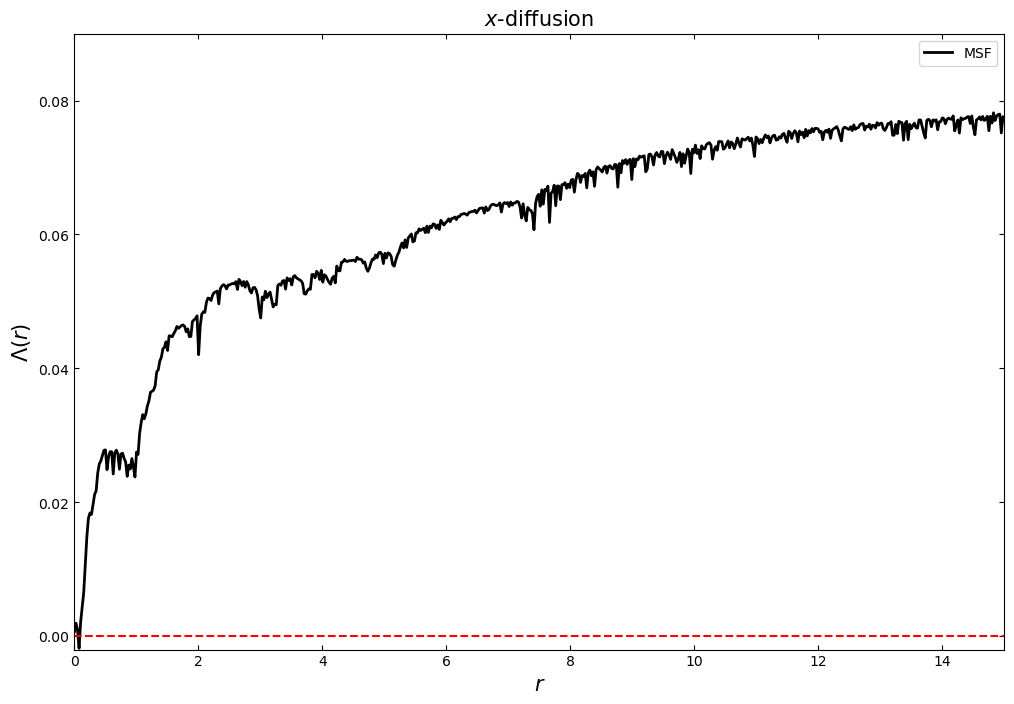

In [25]:
# Plotar MSF
plt.figure(figsize=(12, 8))
plt.plot(r_values, LE_values, 'k', linewidth=2, label='MSF')
plt.axhline(0, color='r', linestyle='--')
plt.xlim(0, 15)
plt.ylim(-0.002, 0.09)
plt.xlabel(r'$r$', fontsize=15)
plt.ylabel(r'$\Lambda(r)$', fontsize=15)
plt.title(r'$x$-diffusion', fontsize=15)
plt.legend()
plt.grid(False)
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.show()